In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models
import gensim
import numpy as np
from gensim.models import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
from sklearn.decomposition import NMF
from collections import defaultdict
import shutil
import os
from sklearn.metrics import jaccard_score

path_to_allrecipes = 'archive/allrecipes-recipes.json.xz'
path_to_kaggle = 'archive/Food Ingredients and Recipe Dataset with Image Name Mapping.csv'
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Clean DataSet

In [2]:
def combine_datasets(path_to_kaggle, path_to_allrecipes):
    def read_file(path):
        recipes_lines = [json.loads(line) for line in open(path, 'r')]
        return pd.DataFrame(recipes_lines)

    df_all_recipies = pd.read_json(path_to_allrecipes,lines=True, compression='xz')
    df_all_recipies = df_all_recipies[df_all_recipies['photo_url'] != "http://images.media-allrecipes.com/global/recipes/nophoto/nopicture-910x511.png"]
    df_all_recipies = df_all_recipies[["ingredients", "instructions", "photo_url", "title"]]
    
    df_kaggle = pd.read_csv(path_to_kaggle)
    df_kaggle['Instructions'] = df_kaggle.apply(lambda x: [x.Instructions], axis=1)
    df_kaggle.rename(columns={"Title":"title", "Cleaned_Ingredients":"ingredients", "Instructions": "instructions", "Image_Name":"photo_url"}, inplace = True)
    df_kaggle = df_kaggle[["ingredients", "instructions", "photo_url", "title"]]
    final_df = pd.concat([df_all_recipies, df_kaggle])
    
    return final_df

def clean_dataset(dataset):
    def remove_values(x):
        prohibitedWords = [' and ', ' with ', ' the ', 'easy', 'best', ' i ', 'ii', 'iii', 'iv']
        big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
        l = [big_regex.sub(" ", str(t).lower()) for t in x]
        return l
    data = dataset.assign(recipe_name = lambda x: remove_values(x['title']))
    return data

def tokenize_words(data):
    de_stop = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')
    final_names=[]
    recipe_name = data['recipe_name'].tolist()
    for rec in recipe_name:
        raw = rec.lower()
        tokens = tokenizer.tokenize(raw)
        stop_t = [recipe_name for recipe_name in tokens if not recipe_name in de_stop]
        stem_t = [i for i in stop_t if len(i)>1]
        if len(stem_t)==0: final_names.append(['error'])
        else: final_names.append(stem_t)
    return (recipe_name, final_names)


In [3]:
data = clean_dataset(combine_datasets(path_to_kaggle, path_to_allrecipes))
recipe_name, final_names = tokenize_words(data)

### Train LDA 

In [4]:
def build_dict_and_corpus(final_names):
    dictionary = corpora.Dictionary(final_names)
    corpus = [dictionary.doc2bow(text) for text in final_names]
    return (dictionary, corpus)

In [20]:
#https://www.statology.org/jaccard-similarity-python/
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

#https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin
def train_lda(corpus, dictionary, final_names):
    num_topics = list(range(50,150,10))
    num_keywords = 15

    LDA_models = {}
    LDA_topics = {}
    for i in num_topics:
        print(i)
        LDA_models[i] = gensim.models.ldamodel.LdaModel(corpus, num_topics=i,passes=1, chunksize=len(corpus), random_state=0, id2word=dictionary)
        shown_topics = LDA_models[i].show_topics(num_topics=i, num_words=num_keywords, formatted=False)
        LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    coherences = [CoherenceModel(model=LDA_models[i], texts=final_names, dictionary=dictionary, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]
    perplexities = [LDA_models[i].log_perplexity(corpus) for i in num_topics[:-1]]
    print("Coherences:", coherences)
    print("Perplexities:", perplexities)
    LDA_stability = {}
    for i in range(0, len(num_topics)-1):
        jaccard_sims = []
        for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
            sims = []
            for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
                sims.append(jaccard(topic1, topic2))    

            jaccard_sims.append(sims)    

        LDA_stability[num_topics[i]] = jaccard_sims

    mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]
    print("Mean Stabilities:", mean_stabilities)
    
    metrics = pd.DataFrame(
    {'Range': num_topics[:-1],
     'Coherences': coherences,
     'Log Perplexities': perplexities,
     'Jaccard Similarity': mean_stabilities
    })
    print(metrics)

    plt.figure(figsize=(7,4))
    ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Jaccard Similarity')
    ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Coherence')

    y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
    ax.set_ylim([0, y_max])
    ax.set_xlim([1, num_topics[-1]-1])

    ax.axes.set_title('Ideal Number of Topics', fontsize=25)
    ax.set_ylabel('Values', fontsize=20)
    ax.set_xlabel('Number of Topics', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()   


50
60
70
80
90
100
110
120
130
140
Coherences: [0.2881875189693908, 0.27034217457012005, 0.2559300195894485, 0.287925915176533, 0.310625846108634, 0.34916380715752604, 0.318758752426189, 0.3658859692552004, 0.4209314126506291]
Perplexities: [-9.538137240704929, -10.953683423462396, -13.430294679053674, -17.199542481755014, -22.612681872766675, -32.00182467496789, -45.47458486717212, -65.19602880859433, -86.71184877783902]
Mean Stabilities: [0.23028356427173458, 0.22478467243124764, 0.18433657978834198, 0.1517778391560064, 0.13130017980664208, 0.08986758290620331, 0.04245215212368896, 0.20285037477964288, 0.4655293860826805]
   Range  Coherences  Log Perplexities  Jaccard Similarity
0     50    0.288188         -9.538137            0.230284
1     60    0.270342        -10.953683            0.224785
2     70    0.255930        -13.430295            0.184337
3     80    0.287926        -17.199542            0.151778
4     90    0.310626        -22.612682            0.131300
5    100    0.

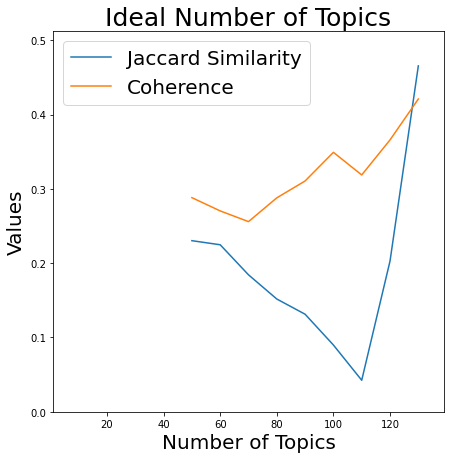

In [8]:
dictionary, corpus = build_dict_and_corpus(final_names)
train_lda(corpus, dictionary, final_names)

### Main LDA

In [9]:
def lda_model(corpus, num_of_topics, dictionary):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_of_topics, passes=1, chunksize=len(corpus), random_state=0, id2word=dictionary)
    return ldamodel

In [10]:
dictionary, corpus = build_dict_and_corpus(final_names)
ldamodel = lda_model(corpus, 110, dictionary)
ldamodel.print_topics(num_topics=110,num_words = 15)

[(0,
  '0.022*"three" + 0.022*"pizza" + 0.022*"sausage" + 0.022*"skillet" + 0.022*"cheese" + 0.022*"style" + 0.022*"johnsonville" + 0.022*"chicken" + 0.022*"italian" + 0.011*"salad" + 0.011*"quinoa" + 0.011*"con" + 0.006*"sweet" + 0.006*"quesadillas" + 0.006*"shoot"'),
 (1,
  '0.013*"chicken" + 0.007*"pepper" + 0.007*"mole" + 0.007*"red" + 0.007*"fingerling" + 0.007*"parsley" + 0.007*"jerk" + 0.007*"cakes" + 0.007*"garlic" + 0.007*"jus" + 0.007*"ice" + 0.007*"eyed" + 0.007*"broccoli" + 0.007*"skillet" + 0.007*"anglaise"'),
 (2,
  '0.007*"halibut" + 0.007*"coconut" + 0.007*"italian" + 0.007*"braised" + 0.007*"cheese" + 0.007*"sausage" + 0.007*"three" + 0.007*"skillet" + 0.007*"lemongrass" + 0.007*"chutney" + 0.007*"ginger" + 0.007*"eggplant" + 0.007*"fillets" + 0.007*"pizza" + 0.007*"style"'),
 (3,
  '0.019*"potato" + 0.012*"bacon" + 0.012*"sausage" + 0.012*"skillet" + 0.012*"italian" + 0.006*"crumbs" + 0.006*"pizza" + 0.006*"pancakes" + 0.006*"medley" + 0.006*"tomatoes" + 0.006*"bisque

### TFIDF

In [11]:
def tfidf_model(final_names):
    data_samples = [' '.join(ti) for ti in final_names]
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=None)
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    return (tfidf, tfidf_feature_names, data_samples)

In [12]:
def rank_terms(A, terms):
    sums = A.sum(axis=0)
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

def visualize_topics(ranking):
    topic_n = []
    for i, pair in enumerate(ranking[0:10]):
        topic_n.append(pair[0])
        print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

In [13]:
tfidf, tfidf_feature_names, data_samples = tfidf_model(final_names)
ranking = rank_terms(tfidf, tfidf_feature_names)
topic_n = visualize_topics(ranking)

01. chicken (2272.10)
02. salad (1798.09)
03. chocolate (1270.53)
04. cake (1231.05)
05. pie (1133.84)
06. soup (1127.89)
07. cheese (1058.56)
08. sauce (1028.70)
09. cookies (1024.20)
10. bread (901.91)


### NMF

In [14]:
def nmf(num_comp, tfidf, final_names):
    nmf = NMF(n_components=num_comp, random_state=1, verbose=1, max_iter=200).fit(tfidf)
    nmf_emb = nmf.transform(tfidf)
    top_idx = np.argsort(nmf_emb,axis=0)[-1:]
    show_ten = num_comp+1
    count_idxs = 0
    final_topics = []
    for idxs in top_idx.T:
        if count_idxs == show_ten: break
        for idx in idxs:
            final_topics.append(final_names[idx])
        count_idxs += 1
    return (nmf, nmf_emb, final_topics)

In [15]:
def print_top_words(model, feature_names, n_top_words):
    manual_topic_cat = []
    for topic_idx, topic in enumerate(model.components_[:50]):
        print("Topic #%d:" % topic_idx)
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            manual_topic_cat.append(feature_names[i])
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return manual_topic_cat

def get_top_recipes_for_category(recipes_all_list, w_vector, recipe_index, top):
    top_indic = np.argsort(w_vector[:,recipe_index])[::-1] 
    top_result = [] 
    for rec_index in top_indic[0:top]:
        top_result.append(recipes_all_list[rec_index])
    return top_result

def get_top_cat_for_recipe(recipes_all_list, w_vector, final_topics):
    final_recipes = []
    recipe_cat_link = []
    for r in range(len(recipes_all_list)):
        one_hot_matrix = w_vector[r,:]
        all_zeros = not one_hot_matrix.any() 
        if all_zeros: 
            recipe_cat_link.append(-1)
        else:
            top_indic = np.argsort(one_hot_matrix)[::-1][0] 
            recipe_cat_link.append(top_indic)
    for num in recipe_cat_link:
        if num == -1: 
            final_recipes.append('no_cat')
        else: 
            final_recipes.append(final_topics[num])
    return final_recipes

In [16]:
nmf_model, nmf_emb, final_topics = nmf(50, tfidf, final_names)
print_top_words(nmf_model, tfidf_feature_names, 10)
top_result = get_top_recipes_for_category(recipe_name, nmf_emb, 1, 10)
print(top_result)
categories_for_recipes = get_top_cat_for_recipe(recipe_name, nmf_emb, final_topics)

C:\Users\Shru\anaconda3\envs\cs7643-a4\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


violation: 1.0
violation: 0.21555600474884604
violation: 0.10909363075245623
violation: 0.06904891874516914
violation: 0.04420786083684349
violation: 0.029282345271575527
violation: 0.022611602935431088
violation: 0.01855918955506079
violation: 0.016163298152217936
violation: 0.013636172602862635
violation: 0.011370435109228333
violation: 0.009477923403495235
violation: 0.008310824305995999
violation: 0.007643950026981199
violation: 0.007061504733384912
violation: 0.006427346173381638
violation: 0.005743804127104362
violation: 0.0052320203719624075
violation: 0.00470556368553437
violation: 0.004199879814591711
violation: 0.0037504422969883745
violation: 0.0033121601743192285
violation: 0.0029483323532507734
violation: 0.002709809758231534
violation: 0.00251114712356137
violation: 0.0023564266701606496
violation: 0.002227076942808158
violation: 0.002130105498372852
violation: 0.002054679920846469
violation: 0.0020009240795440556
violation: 0.001963541618408623
violation: 0.0019343230866

In [17]:
categories_for_recipes_35 = categories_for_recipes

In [18]:
categories_for_recipes 

[['roasted', 'chicken'],
 ['cheese', 'baked', 'macaroni', 'cheese'],
 ['bread'],
 ['bread'],
 ['cranberry', 'orange', 'cookies'],
 ['banana', 'banana', 'bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['stuffed', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['pumpkin', 'cake'],
 ['bread'],
 ['banana', 'banana', 'bread'],
 ['bread'],
 ['bread'],
 ['banana', 'banana', 'bread'],
 ['bread'],
 ['bread'],
 ['tomato', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['muffins'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['muffins'],
 ['bread'],
 ['bread'],
 ['chocolate', 'chocolate', 'chip', 'cookies'],
 ['banana', 'banana', 'bread'],
 ['banana', 'banana', 'bread'],
 ['banana', 'banana', 'bread'],
 ['bacon'],
 ['bread'],
 ['garlic', 'steak', 'garlic'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['stra

### Categorize Images

In [19]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def movePic(src, dest):
    shutil.copy(src, dest)
    
def categorize_folders(data, categories_for_recipes):
    data['category'] = categories_for_recipes
    directories_names = []

    for directt in categories_for_recipes:
        d_name = '_'.join(directt)
        directories_names.append(d_name)

    for curr_dir_category in directories_names:
        createFolder('archive/input/images/images/' + curr_dir_category)
    data['directories_names'] = directories_names
    return data

def classify_images(data):
    image_category = defaultdict(list)
    for index, row in data.iterrows():
        image_category[row.directories_names].append(row.photo_url)
        
    for directory in image_category.keys():
        print(directory+':')
        for image in image_category[directory]:
            if "http://images.media-allrecipes.com/" in image:
                image_dir = image.split(".com")[1]
                image_name = image_dir.split('/')[-1]
                try:
                    movePic(r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive"+image_dir, r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/input/images/images/"+directory+'/'+image_name)
                except:
                    print(image_dir)
            else:
                try:
                    movePic(r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/dataset/"+image+'.jpg', r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/input/images/images/"+directory+'/'+image+'.jpg')
                except:
                    print(image)

In [51]:
data = categorize_folders(data, categories_for_recipes)
classify_images(data)

roasted_chicken:
#NAME?
cheese_baked_macaroni_cheese:
bread:
/userphotos/560x315/1122530.jpg
/userphotos/560x315/1168027.jpg
/userphotos/560x315/1117377.jpg
/userphotos/560x315/1114935.jpg
cranberry_orange_cookies:
banana_banana_bread:
/userphotos/560x315/2279903.jpg
/userphotos/560x315/1123345.jpg
stuffed_chicken:
/userphotos/560x315/1122101.jpg
#NAME?
#NAME?
pumpkin_cake:
/userphotos/250x250/979703.jpg
/userphotos/560x315/1096676.jpg
#NAME?
#NAME?
tomato_chicken:
/userphotos/250x250/979815.jpg
#NAME?
muffins:
/userphotos/560x315/1118491.jpg
/userphotos/560x315/1121576.jpg
chocolate_chocolate_chip_cookies:
/userphotos/560x315/1116488.jpg
/userphotos/560x315/1123977.jpg
/userphotos/560x315/1121100.jpg
/userphotos/250x250/979740.jpg
/userphotos/560x315/1114479.jpg
bacon:
/userphotos/560x315/1122561.jpg
/userphotos/560x315/1119728.jpg
/userphotos/560x315/1117012.jpg
#NAME?
garlic_steak_garlic:
/userphotos/560x315/1122222.jpg
/userphotos/560x315/1121479.jpg
strawberry_chicken:
/userphotos

In [58]:
pd.set_option('display.max_rows', 500)
data = categorize_folders(data, categories_for_recipes)
data[:200]

,ingredients,instructions,photo_url,title,recipe_name,category,directories_names
0,"[1/2 cup unsalted butter, chilled and cubed, 1...",[Preheat oven to 400 degrees F (205 degrees C)...,http://images.media-allrecipes.com/userphotos/...,"Basil, Roasted Peppers and Monterey Jack Cornb...","basil, roasted peppers monterey jack cornbread","[roasted, garlic, potatoes]",roasted_garlic_potatoes
1,"[1/2 cup Parmesan cheese, 3/4 teaspoon ground ...","[Combine parmesan cheese, pepper and garlic po...",http://images.media-allrecipes.com/userphotos/...,Crispy Cheese Twists,crispy cheese twists,"[cheese, baked, macaroni, cheese]",cheese_baked_macaroni_cheese
2,"[2 cups hot water, 1/2 cup margarine, 1/3 cup ...",[Melt margarine in hot water. Add sugar and sa...,http://images.media-allrecipes.com/userphotos/...,Mom's Yeast Rolls,mom's yeast rolls,[bread],bread
3,"[1 1/2 cups white sugar, 1/2 cup vegetable oil...",[Combine sugar and oil; beat well. Add eggs an...,http://images.media-allrecipes.com/userphotos/...,Sweet Potato Bread I,sweet potato bread i,"[sweet, potato, potato, salad]",sweet_potato_potato_salad
4,"[1/4 cup butter, 1 teaspoon white sugar, 1 cup...",[Stir butter and 1 teaspoon sugar into the hot...,http://images.media-allrecipes.com/userphotos/...,Orange Buns,orange buns,"[cranberry, orange, cookies]",cranberry_orange_cookies
5,"[1 teaspoon active dry yeast, 1 1/4 cups lukew...","[In a small bowl, dissolve the yeast in the mi...",http://images.media-allrecipes.com/userphotos/...,Cornish Splits,cornish splits,"[cranberry, orange, cookies]",cranberry_orange_cookies
6,"[8 cups all-purpose flour, 4 cups shredded Che...","[In a very large bowl, combine 7 cups of flour...",http://images.media-allrecipes.com/userphotos/...,Jalapeno Cheese Bread,jalapeno cheese bread,[bread],bread
7,"[2 tablespoons active dry yeast, 1 teaspoon wh...","[In a small bowl, dissolve the yeast and sugar...",http://images.media-allrecipes.com/userphotos/...,Dee's Health Bread,dee's health bread,[bread],bread
8,"[1 cup rolled oats, 1/2 cup molasses, 1/3 cup ...","[Combine oats, molasses, oil, salt and boiling...",http://images.media-allrecipes.com/userphotos/...,Oatmeal Bread I,oatmeal bread i,[bread],bread
9,"[3 cups all-purpose flour, 2 cups white sugar,...",[Grease and flour a 9 x 5 inch pan well. Prehe...,http://images.media-allrecipes.com/userphotos/...,Strawberry Bread I,strawberry bread i,[bread],bread


In [52]:
data.to_csv('C:\\Users\\Shru\\Desktop\\Georgia Tech Master\\Summer 2022\\project\\archive\\recipe_name_image_lookup.csv')

In [25]:
ALL_IMGS_DIR = 'archive/input/images/images/'

for directory_ in image_category.keys():
    print('{} -> '.format(directory_), end='')
    print(len([name for name in os.listdir(os.path.join(ALL_IMGS_DIR, directory_)) if name.endswith(".jpg")]), end='\n')

roasted_chicken -> 1754
cheese_baked_macaroni_cheese -> 1153
bread -> 2447
cranberry_orange_cookies -> 1370
banana_banana_bread -> 1757
stuffed_chicken -> 1871
pumpkin_cake -> 1087
tomato_chicken -> 1226
muffins -> 1027
chocolate_chocolate_chip_cookies -> 3638
bacon -> 2446
garlic_steak_garlic -> 1182
strawberry_chicken -> 1319
red_pepper_chicken -> 2223
sweet_spicy_sweet_potatoes -> 1277
coconut_chicken -> 2071
pie_strawberry_pie -> 3166
turkey -> 1846
chicken_pizza -> 1098
ham_pineapple -> 796
apple_salad -> 1794
italian_style_sausage -> 1659
spinach_salad -> 1122
sweet_potato_potato_salad -> 769
corn_salad -> 720
dip -> 2136
chili -> 1375
baked_chicken -> 1952
sweet_cream_ice_cream -> 1281
chicken_shrimp -> 1845
zucchini_salad -> 522
bars -> 1212
lemon_lemon_loaf -> 1731
salad -> 4662
beef_stew -> 3318
creamy_chicken -> 1328
peanut_butter -> 2002
n_o___c_a_t -> 513
cake -> 3507
broccoli_bake -> 1022
pork_chops -> 1163
ham_sauce_mustard_sauce -> 2324
rice -> 2033
green_bean_salad -> 

In [24]:
data = categorize_folders(data, categories_for_recipes)
image_category = defaultdict(list)
for index, row in data.iterrows():
    image_category[row.directories_names].append(row.photo_url)